# NE 204 Lab 2 Analysis
## Kalie Knecht
Lab Partners: Ian Kolaja and Trevor Arino

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum, find_compton_edge
from pulse_shape import find_rise_time

## import data

In [2]:
# # function imports data, removes duplicate events, and converts to np.int16
# # type conversion to np.int16 takes some time


print('cs far')
f_name = './data/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

# print('cs close')
# f_name = './data/cs_close.h5'
# f_data = h5py.File(f_name,'r')
# cs_close = f_data['raw_data'][()]
# cs_close_events = f_data['event_data'][()]
# print(str(cs_close.shape[0])+' events')


# calibration data from last lab - might use, might not
# print('co calibration')
# f_name = './data/co.h5'
# f_data = h5py.File(f_name,'r')
# co = f_data['raw_data'][()]
# co_events = f_data['event_data'][()]
# print(str(co.shape[0])+' events')

# print('ba calibration')
# f_name = './data/ba.h5'
# f_data = h5py.File(f_name,'r')
# ba = f_data['raw_data'][()]
# ba_events = f_data['event_data'][()]
# print(str(ba.shape[0])+' events')

# pulser noise data
# f_name = './data/pulser.h5'
# f_data = h5py.File(f_name,'r')
# noise = f_data['raw_data'][()]
# noise_events = f_data['event_data'][()]
# print(str(noise.shape[0])+' events')

cs far
152057 events


## Calibration source information
* Cs-137
    * 10.2 $\mu$Ci, 377.4 kBq, 1-Jun-13
    * half life: 30.08(9) y (NNDC)
    * source strength on 10/28/22: 8.21 $\mu$Ci
    * Associated gamma-ray energy:
        * 662 keV, 85.10(20) %

In [3]:
# find source activties during measurement
# function syntax (half-life, initial activity, time since born date (in units of half-life))
# function output: activity during measurement in units of initial activity
print('Cs137')
Acs = find_activity(30.09,10.2,9 + 4/12 + 27/365.25)
print('10/28: ',Acs)

Cs137
10/28:  8.212719257704487


## Plot raw waveforms
From plotting we can see some additional cleanup is necessary

In [130]:
# convert waveform time scale to nanoseconds
wave_times = np.linspace(0,1/(250*10**6)*50000*10**9,50000)
# wave_times_cropped = np.linspace(0,1/(250*10**6)*20000*10**9,20000)

<IPython.core.display.Javascript object>


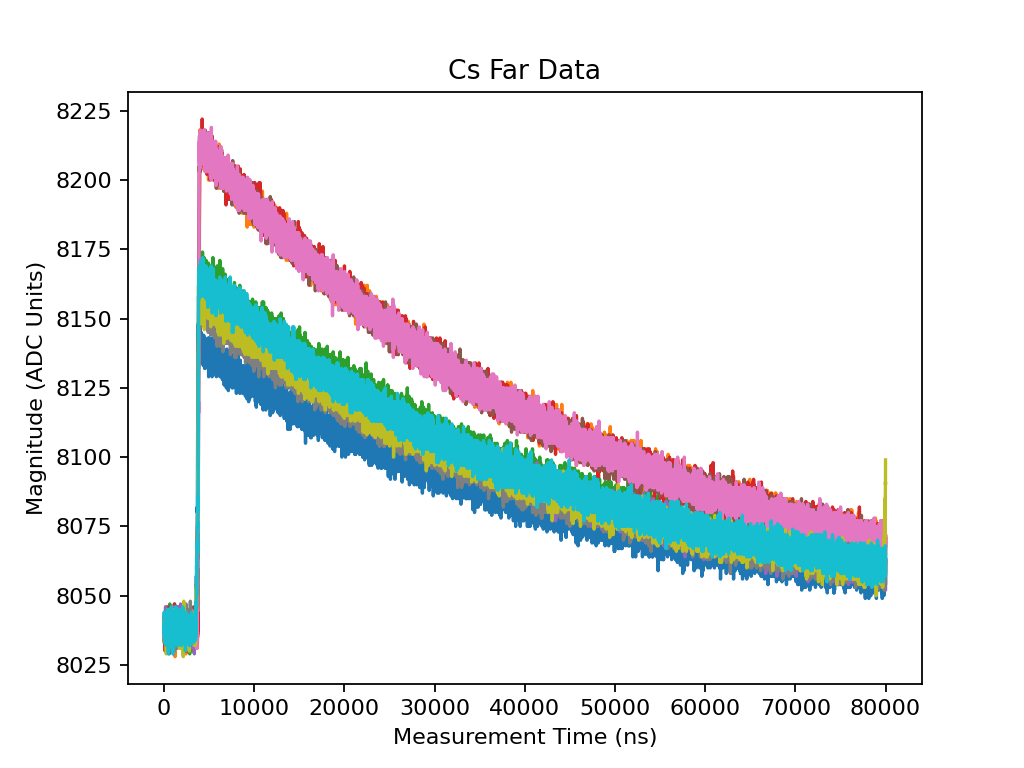

In [22]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs_cropped))
    plt.plot(wave_times_cropped,cs_cropped[n])
#plt.xlim(920,1150)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.title('Cs Far Data')
plt.show()

<IPython.core.display.Javascript object>


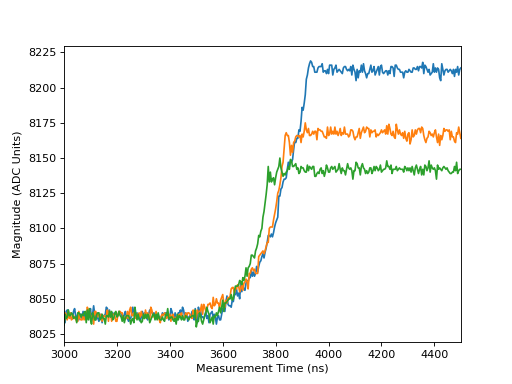

In [5]:
# plot random pulses
# number of random pulses
number_of_pulses = 3
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs))
    plt.plot(wave_times,cs[n])
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
# plt.title('Cs Far Da')
# plt.savefig('figs/diff_pulse_shapes.png')
plt.show()

<IPython.core.display.Javascript object>


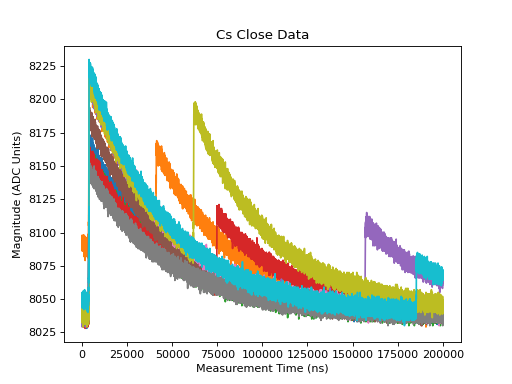

In [6]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs_close))
    plt.plot(wave_times,cs_close[n])
#plt.xlim(920,1150)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.title('Cs Close Data')
plt.show()

<IPython.core.display.Javascript object>


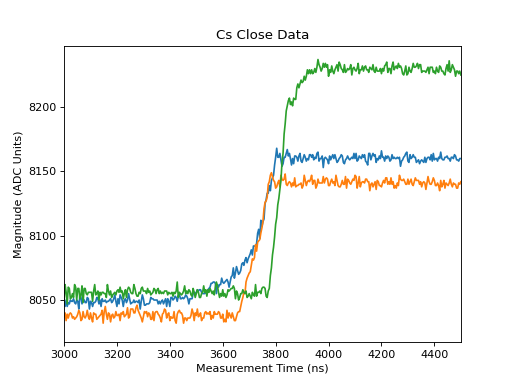

In [7]:
# plot random pulses
# number of random pulses
number_of_pulses = 3
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs_close))
    plt.plot(wave_times,cs_close[n])
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.title('Cs Close Data')
plt.show()

# Lab 2 requirements
Digitized preamplifier voltage signals are used as the basis for determining the position of interaction of a gamma ray relative to the electrodes of a semiconductor detector. Pulse shape analysis techniques for de-convolving multiple gamma-ray interactions will be investigated. The application of event-selection filters will be evaluated in terms of the overall spectral response, including the peak-to-Compton (PC) and peak-to-total (PT) ratios. In addition, the trade-offs between pulse pile-up and optimal SNR performance will be evaluated for high-rate gamma-ray spectroscopy.


Develop techniques to correlate the interaction history of individual gamma rays in the detector to the corresponding preamplifier signal. Consider parameterizing the time profile of the rising edge of the signal in terms of fractions of total induced charge. For example, the rise-time of a signal is usually defined as the time it takes for the signal to rise from 10% of maximum to 90% of maximum, or trise = t90 - t10. Create energy spectra using only signals within various ranges of rise time: comment on variations in the PC and PT ratios. Given these correlations (if any), can you devise a simple gamma-ray event-selection filter to improve the PC ratio?

Required: 
* Devise an event selection filter based on signal shape and quantitatively evaluate its effect on gamma-ray energy spectra in terms of total counts and PC ratio. Provide a theoretical justification for the event selection procedure you are proposing.
* Evaluate and compare multiple event selection filters and quantify their impact on gamma-ray spectra.
* Identify multiple-site interaction events and justify your selection process.
* Using a strong gamma-ray source, evaluate the trade-offs between energy resolution and pile-up (or throughput) for triangular/trapezoidal shaping filters with various peaking & gap times.


* On Friday for ideas and he said the clustering thing from his slides, or he also suggested using an integral based filter when looking at the rise times (which seemed a lot easier to me) ?

Optional:
* Use the Shockley-Ramo theorem and conventional electrostatics to predict the signal shape for gamma-ray interaction positions with in the detector. Using a collimated gamma-ray source, experimentally validate your predicted signal shape. 

In [5]:
# downsample data so filters can handle it
# maybe your computer is better than mine and you can remove the downsampling
cs_down = cs[::10]
print(len(cs_down))
# cs_close_down = cs_close[::4]
# print(len(cs_close_down))

15206


In [190]:
# get rise times

In [6]:
far_rise_times = np.zeros(len(cs_down))
for i in range(len(cs_down)):
    far_rise_times[i] = find_rise_time(cs_down[i])

In [3]:
rise_times = np.zeros(len(cs))
for i in range(len(cs)):
    rise_times[i] = find_rise_time(cs[i])

In [4]:
fast_pulses = np.argwhere(rise_times<rise_times.mean()-rise_times.std()).flatten()
ave_pulses = np.argwhere(np.isclose(rise_times,rise_times)).flatten()
slow_pulses = np.argwhere(rise_times>rise_times.mean()+rise_times.std()).flatten()

In [7]:
# close_rise_times = np.zeros(len(cs_close_down))
# for i in range(len(cs_close_down)):
#     close_rise_times[i] = find_rise_time(cs_close_down[i])

In [95]:
low_rise_pulses = np.argwhere(far_rise_times<far_rise_times.mean()-far_rise_times.std()).flatten()
ave_rise_pulses = np.argwhere(np.isclose(far_rise_times,far_rise_times)).flatten()
high_rise_pulses = np.argwhere(far_rise_times>far_rise_times.mean()+far_rise_times.std()).flatten()

In [153]:
rise_times.mean()*10**9

226.33478235135507

In [154]:
rise_times.std()*10**9

102.57490708689305

<IPython.core.display.Javascript object>


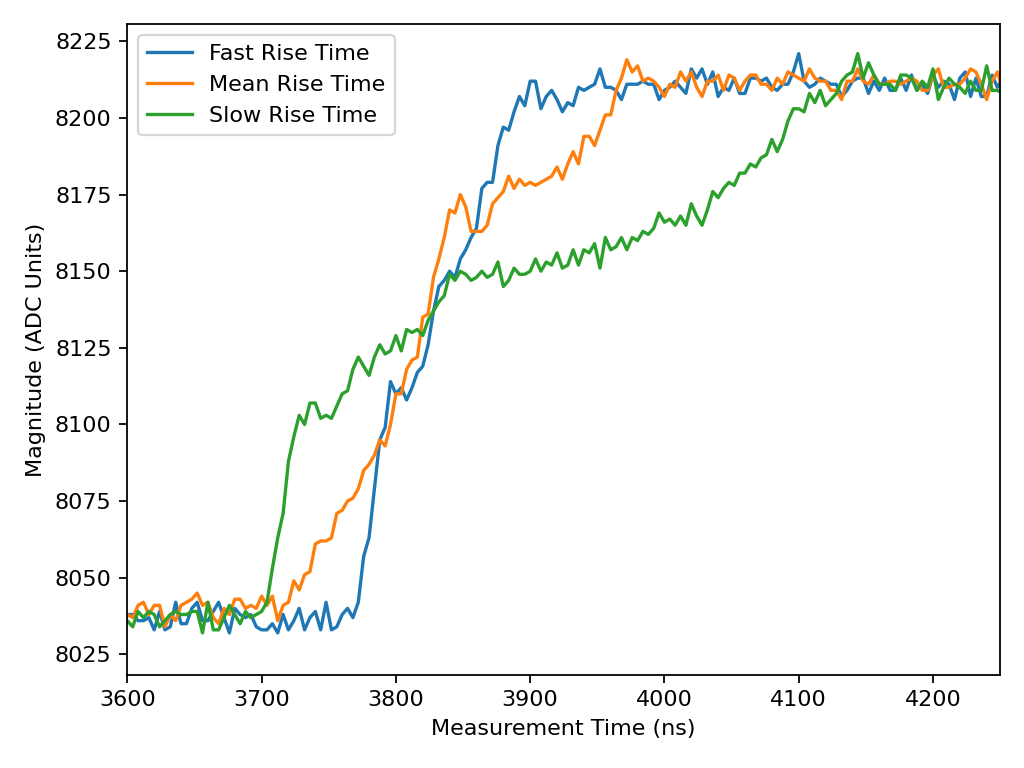

In [150]:
plt.figure()
plt.plot(wave_times,cs[fast_pulses[3]],label='Fast Rise Time')
plt.plot(wave_times,cs[ave_pulses[0]],label='Mean Rise Time')
plt.plot(wave_times,cs[slow_pulses[0]],label='Slow Rise Time')
plt.xlim(3600,4250)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.legend()
plt.tight_layout()
plt.savefig('figs/example_rise_time_pulses')
plt.show()

<IPython.core.display.Javascript object>


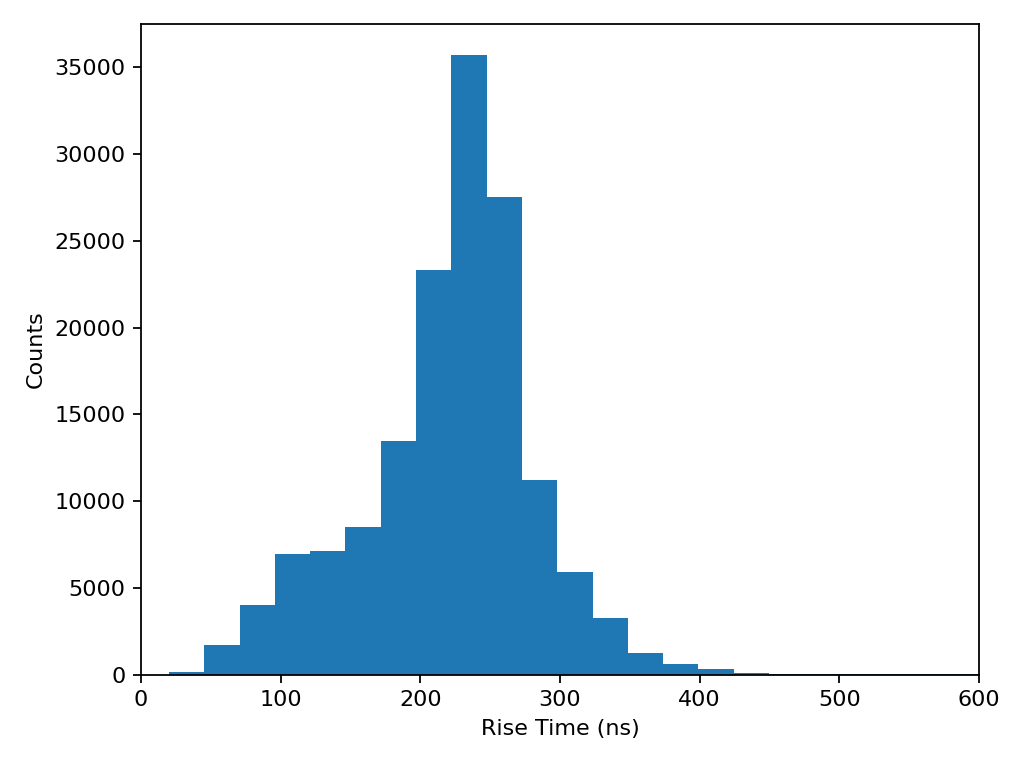

In [151]:
hist_bins=100
plt.figure()
plt.hist(rise_times*10**9,bins=hist_bins)
# plt.hist(close_rise_times*10**9,bins=hist_bins,alpha=0.5,label='2 cm')
plt.xlim(0,600)
plt.xlabel('Rise Time (ns)')
plt.ylabel('Counts')
plt.tight_layout()
# plt.legend()
plt.savefig('figs/rise_time_hist.png')
plt.show()

# apply trapezoidal filter to raw waveform

In [5]:
# Use same filter parameters as lab 1
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)
peaking_time = 100 * 4 * 10**(-9)
gap_time = peaking_time * 5  

print('Filter parameters:')
print('tau =',tau)
print('peaking time = ', peaking_time)
print('gap time = ', gap_time)

Filter parameters:
tau = 4.3869703144020734e-05
peaking time =  4.0000000000000003e-07
gap time =  2.0000000000000003e-06


In [6]:
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [7]:
cs_cropped = cs[:,0:15000]

In [8]:
# filtered_cs = Cooper_filter.filter_waveform(cs_down,normalize=True)
# filtered_cs = Cooper_filter.filter_waveform(cs,normalize=True)
filtered_cs = Cooper_filter.filter_waveform(cs_cropped,normalize=True)

In [12]:
# filtered_cs_close = Cooper_filter.filter_waveform(cs_close_down,normalize=True)

In [20]:
# all_filtered_waveforms = np.concatenate((filtered_cs,filtered_cs_close),axis=0)

# Spectral analysis
## Load all data into a spectrum

In [9]:
# load filtered waveforms into 'spectrum'
spec = spectrum(filtered_cs,bins=2000)

In [11]:
# relevant gamma energies
# energies=[356.0129, 661.7,  1173.228, 1332.492]
# compton_edges = np.array([477.,963.,1118.])
compton_edges = np.array([477.])
# # k40 and tl208
# background_peaks = np.array([1460.820,1764,2614.511])
# possible_pileups = np.array([1173.228+1332.492,662*2,1173.228*2,1332.492*2])

# energies = [356.0129, 661.7,  1173.228, 1332.492, 1460.820]
energies = [661.7]

# provide energies of gamma peaks selected by peak fitting algorithm
# spec.find_energy_calibration(energies=energies,alternative='greater')

In [109]:
spec.run_full_pipeline(energies,prominence=100)

Finding Peaks
Fitting gaussian
Finding energy calibration
Done!
pc ratio: 21.138442131819613
pt ratio: 0.04450508591612886


<IPython.core.display.Javascript object>


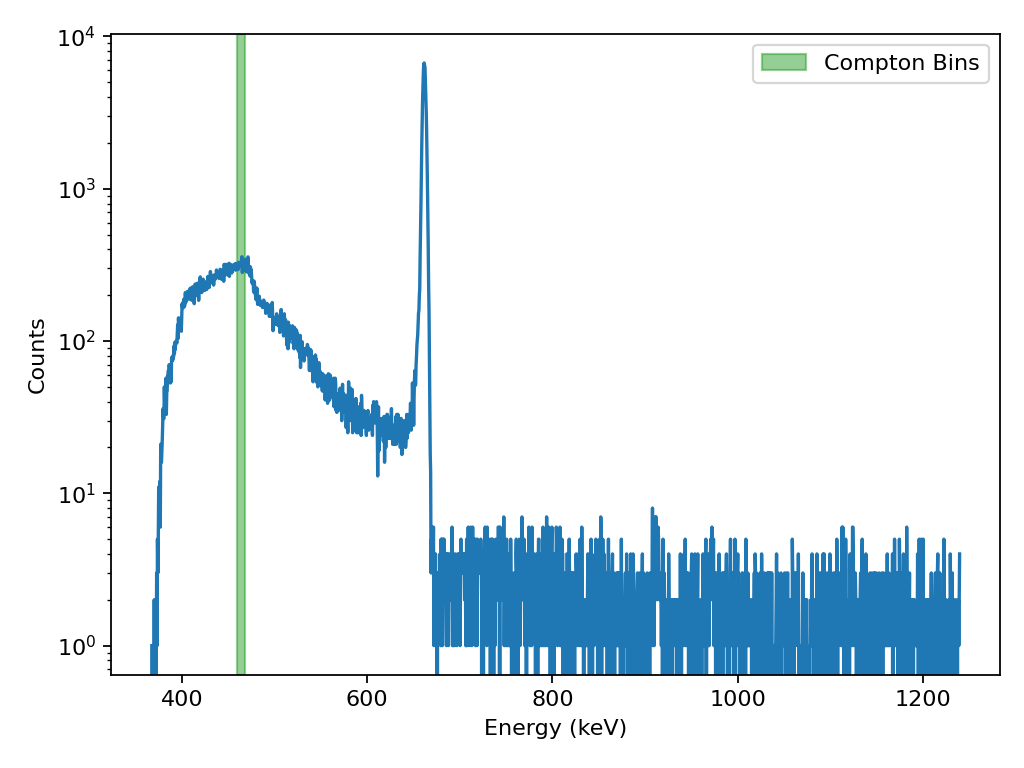

In [155]:
from spectrum import find_compton_edge
compton_setback = 30
compton_bin_width = 10
photopeak_counts = spec.counts[spec.peaks]
compton_edge = find_compton_edge(spec.energies[0])
compton_edge_channels = np.argwhere(np.isclose(spec.bin_energies,compton_edge,atol=1)).flatten()
compton_counts = spec.counts[(compton_edge_channels[0]-compton_setback-compton_bin_width):compton_edge_channels[0]-compton_setback+compton_bin_width].mean()



# see spectrum with x-axis as energy
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.axvspan(spec.bin_energies[compton_edge_channels[0]-compton_bin_width-compton_setback],spec.bin_energies[compton_edge_channels[0]-compton_setback+compton_bin_width],alpha=.5,color='tab:green',label='Compton Bins')
plt.legend()
plt.tight_layout()
plt.savefig('figs/pc_ratio.png')


<IPython.core.display.Javascript object>


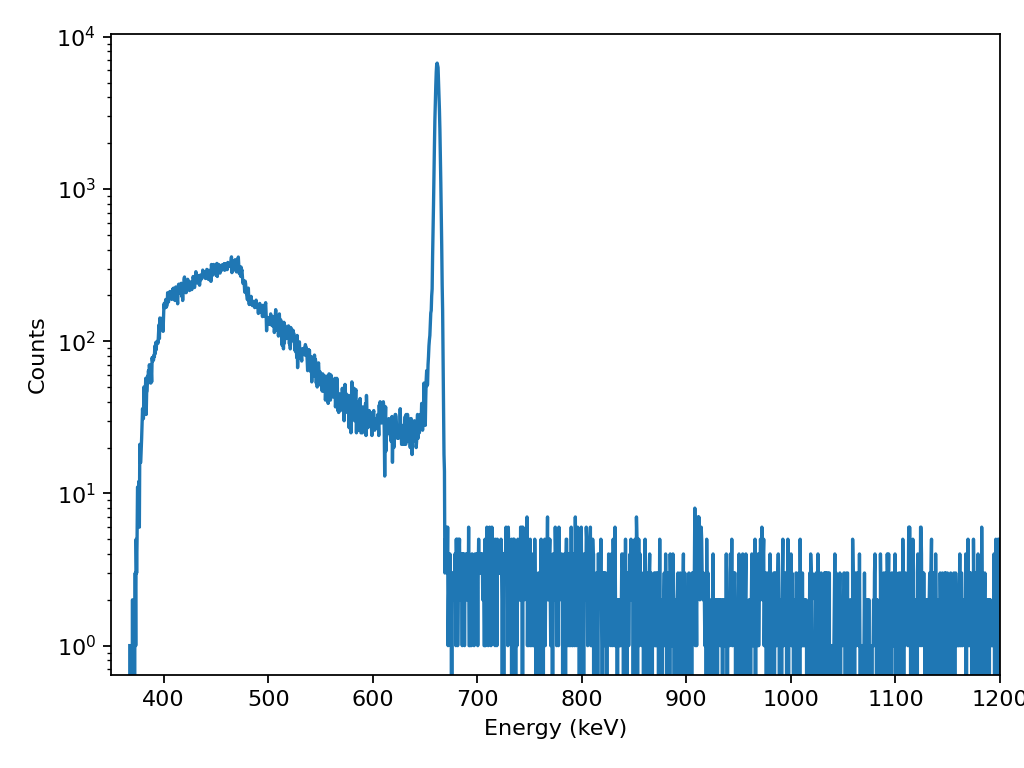

In [170]:
# see spectrum with x-axis as energy
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.xlim(350,1200)
plt.savefig('figs/spectrum_all_events.png')

In [160]:
spec.counts.sum()

150612

# fast rise pulse analysis

In [114]:
spec_fast = spectrum(filtered_cs[fast_pulses],bins=2000)

In [115]:
spec_fast.run_full_pipeline(energies,width = [0,20])

Finding Peaks
Fitting gaussian
Finding energy calibration
Done!
pc ratio: 23.639774859287055
pt ratio: 0.049629746336852056


<IPython.core.display.Javascript object>


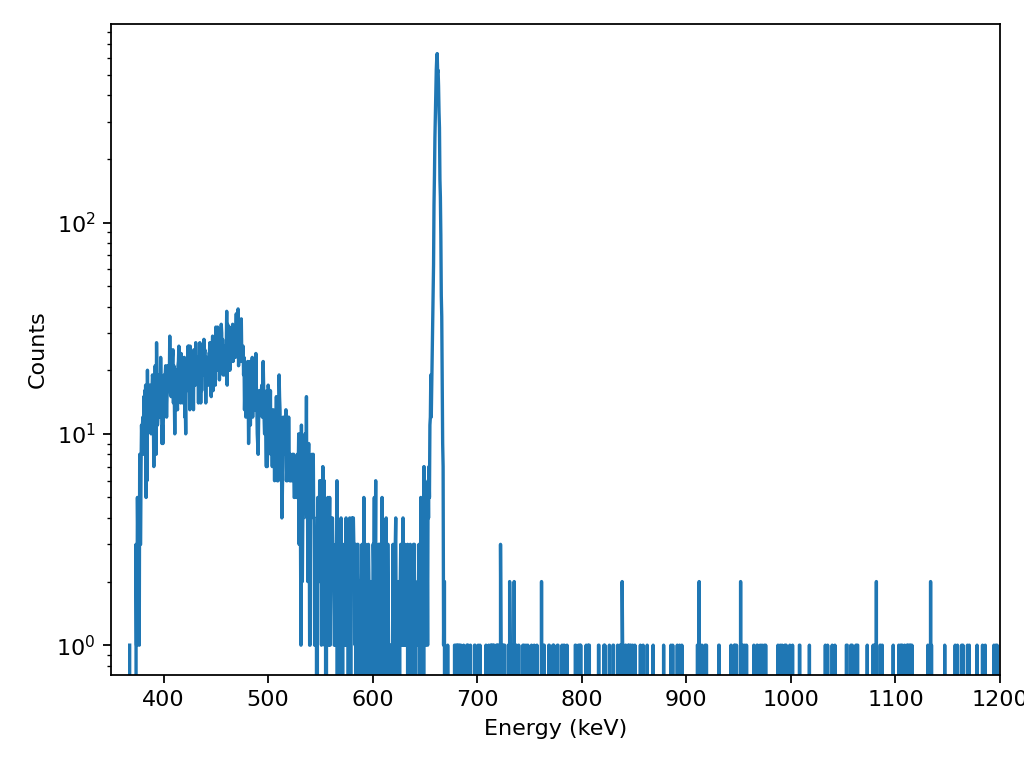

In [169]:
# see spectrum with x-axis as energy
spec_fast.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.xlim(350,1200)
plt.savefig('figs/spectrum_fast_events.png')

<IPython.core.display.Javascript object>


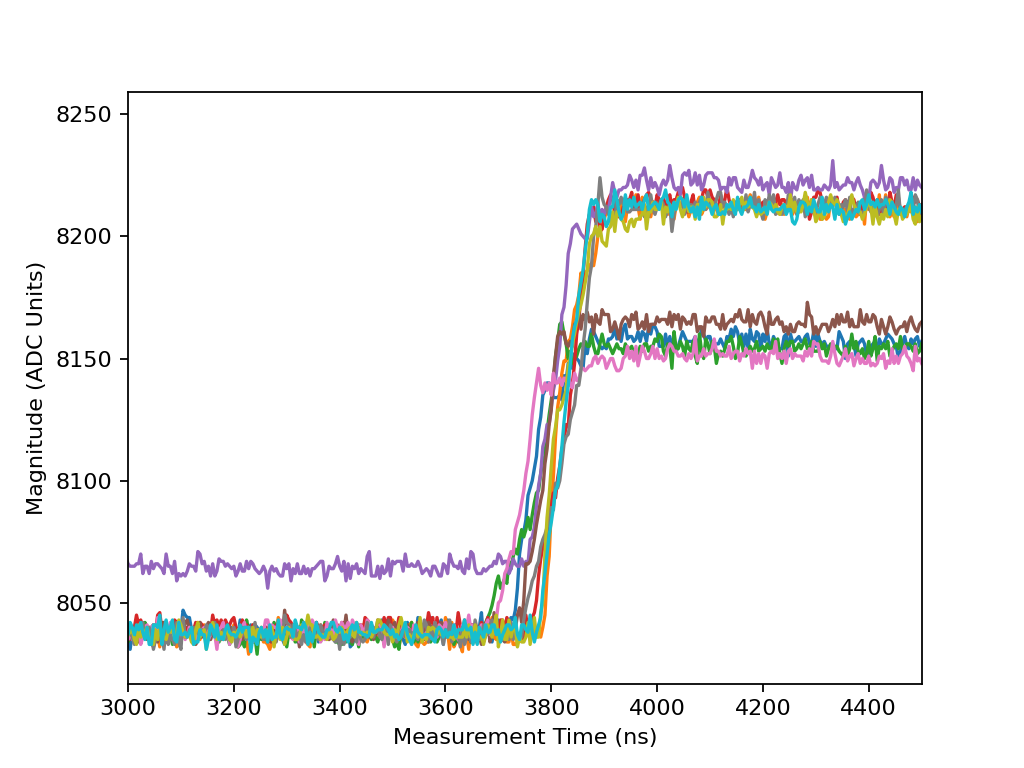

In [135]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(fast_pulses))
    plt.plot(wave_times,cs[fast_pulses[n]])
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
# plt.title('Cs Far Da')
# plt.savefig('figs/diff_pulse_shapes.png')
plt.show()

In [161]:
spec_fast.counts.sum()

12694

# slow rise pulse analysis

In [118]:
spec_slow = spectrum(filtered_cs[slow_pulses],bins=2000)

In [119]:
spec_slow.run_full_pipeline(energies,prominence=20,width=[0,20])

Finding Peaks
Fitting gaussian
Finding energy calibration
Done!
pc ratio: 50.18518518518518
pt ratio: 0.05210536435300904


<IPython.core.display.Javascript object>


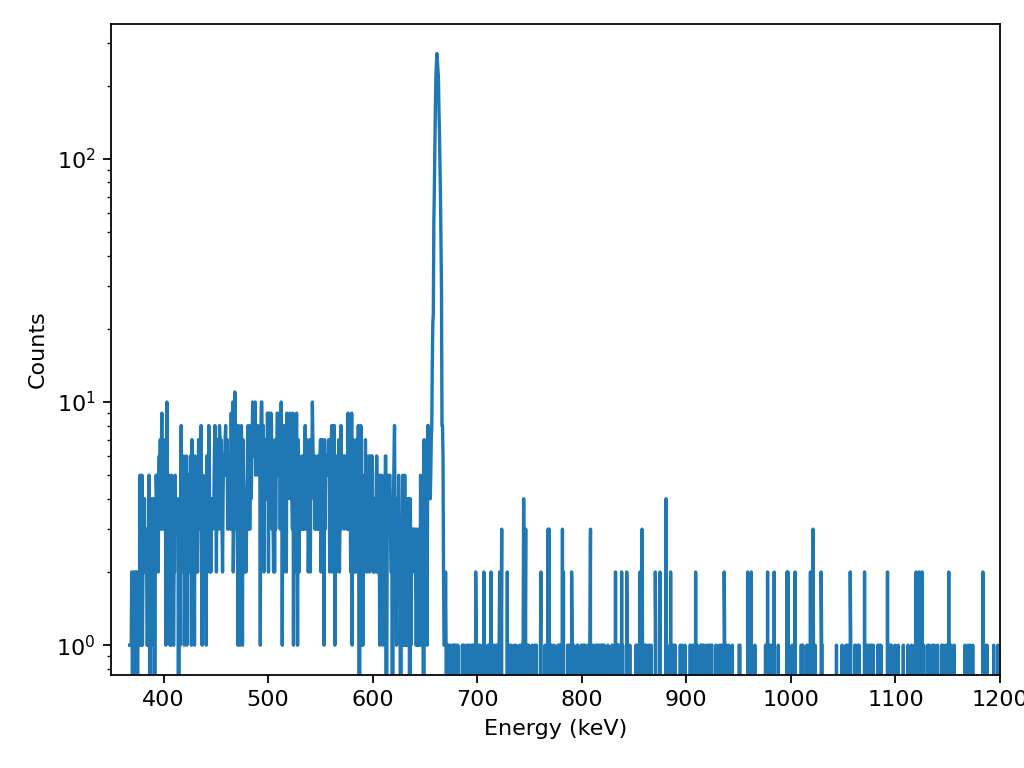

In [168]:
# see spectrum with x-axis as energy
spec_slow.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.xlim(350,1200)
plt.savefig('figs/spectrum_slow_events.png')

In [123]:
spec_slow.counts.sum()

5201

<IPython.core.display.Javascript object>


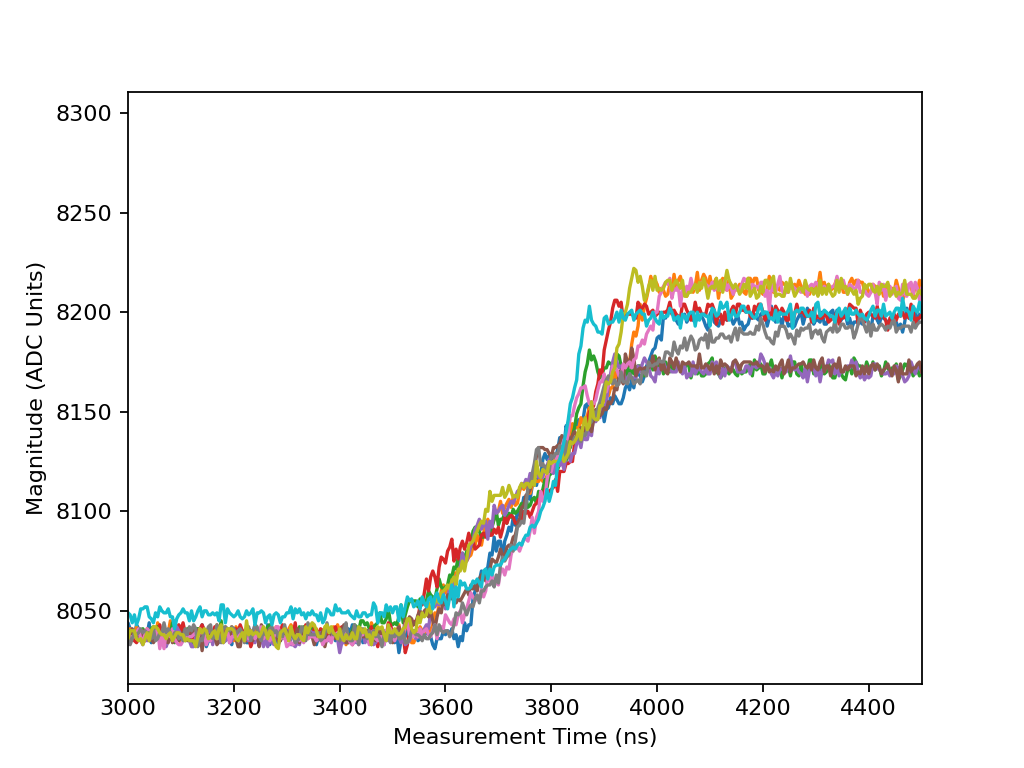

In [132]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(slow_pulses))
    plt.plot(wave_times,cs[slow_pulses[n]])
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
# plt.title('Cs Far Da')
# plt.savefig('figs/diff_pulse_shapes.png')
plt.show()

# ave rise time analsys

In [ ]:
spec_ave = spectrum(filtered_cs[ave_pulses],bins=2000)

In [127]:
spec_ave.run_full_pipeline(energies,prominence=100,width=[0,10])

Finding Peaks
Fitting gaussian
Finding energy calibration
Done!
pc ratio: 21.138442131819613
pt ratio: 0.04450508591612886


<IPython.core.display.Javascript object>


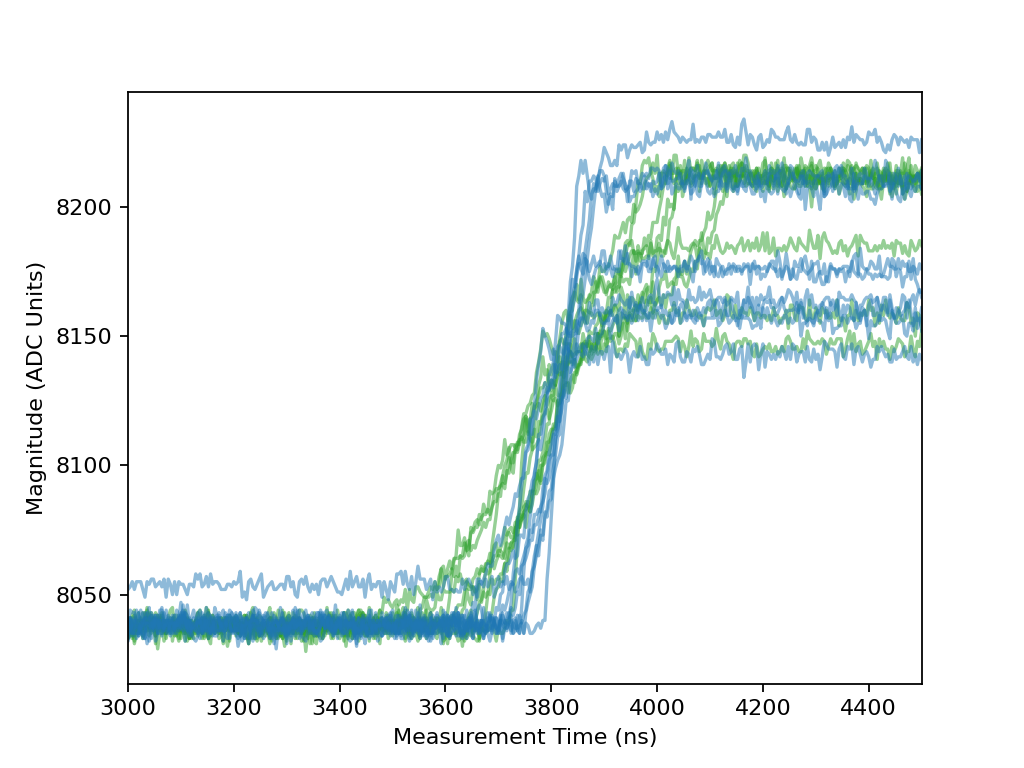

In [136]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(slow_pulses))
    plt.plot(wave_times,cs[slow_pulses[n]],c='tab:green',alpha=0.5)
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(fast_pulses))
    plt.plot(wave_times,cs[fast_pulses[n]],c='tab:blue',alpha=0.5)
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
# plt.title('Cs Far Da')
# plt.savefig('figs/diff_pulse_shapes.png')
plt.show()

# multi interaction events

<IPython.core.display.Javascript object>


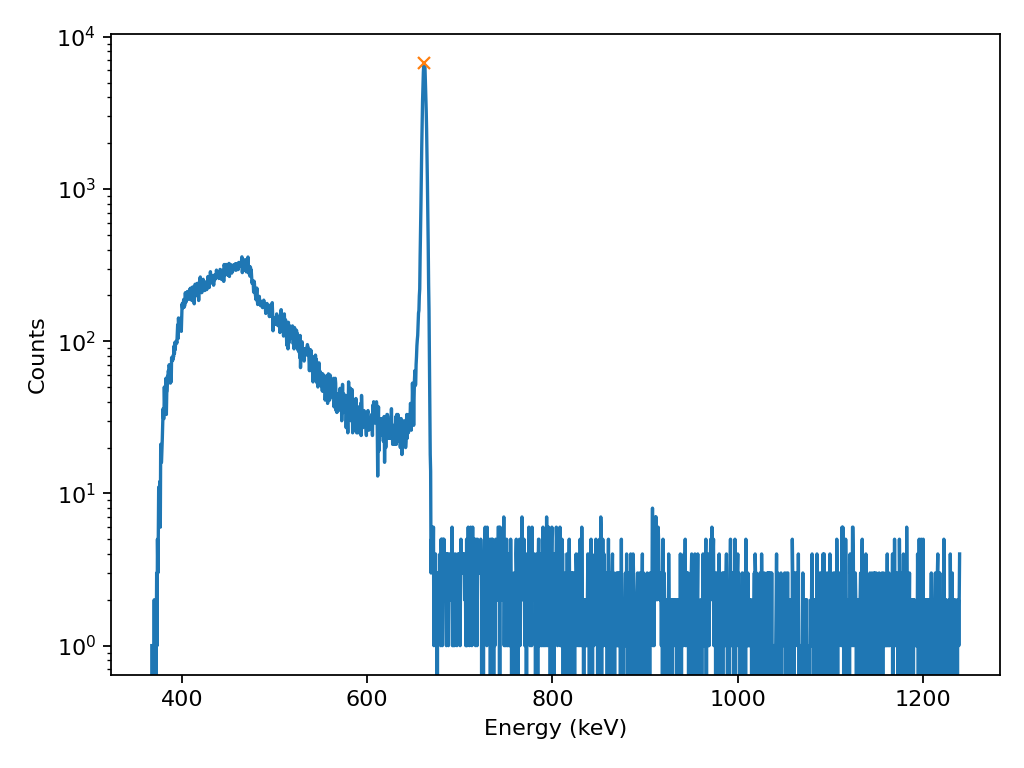

In [172]:
spec.plot_spectrum(semilogy=True)

In [178]:
compton_edge_E = find_compton_edge(661.7)

In [199]:
shoulder_mask = spec.bin_energies > compton_edge_E
shoulder_mask *= spec.bin_energies < 661.7
shoulder_idx = np.argwhere(shoulder_mask).flatten()
# add buffer to account for energy resolution
buffer = 10
shoulder_idx = shoulder_idx[buffer:len(shoulder_idx)-buffer]
spec.counts[shoulder_idx]

array([174, 189, 175, 182, 197, 181, 179, 171, 183, 180, 180, 173, 166,
       172, 168, 186, 175, 167, 172, 165, 152, 165, 166, 177, 155, 168,
       159, 164, 160, 145, 172, 161, 146, 150, 165, 173, 179, 149, 117,
       141, 142, 143, 129, 142, 130, 138, 134, 151, 128, 140, 140, 126,
       132, 145, 137, 114, 124, 145, 161, 137, 118, 122, 143, 131, 108,
       127, 151, 124, 111, 138, 115, 113,  94, 108, 126,  89, 133,  97,
       127, 118, 116, 108, 104, 113, 112, 119, 126, 122,  96, 111,  89,
       123, 119, 100, 103, 106, 118, 112, 112, 101,  87,  97,  85,  99,
        78, 109,  67,  85,  88,  93,  99,  81,  88,  77,  79,  74,  89,
        86,  86,  89,  90,  88,  81,  95,  92,  91,  88,  76,  64,  74,
        88,  79,  87,  72,  77,  63,  79,  54,  73,  66,  78,  66,  59,
        81,  71,  76,  72,  53,  69,  50,  62,  70,  72,  61,  55,  63,
        62,  51,  53,  51,  47,  61,  60,  47,  50,  51,  59,  41,  49,
        47,  43,  59,  55,  39,  43,  61,  46,  43,  41,  60,  5

In [208]:
shoulder_trap_heights_min = spec.bin_edges[shoulder_idx][0]
shoulder_trap_heights_max = spec.bin_edges[shoulder_idx][-1]

In [213]:
mask = spec.trapezoid_heights < shoulder_trap_heights_max
mask *= spec.trapezoid_heights > shoulder_trap_heights_min
shoulder_pulse_idx = np.argwhere(mask).flatten()

In [218]:
shoulder_pulses = cs[shoulder_pulse_idx]

<IPython.core.display.Javascript object>


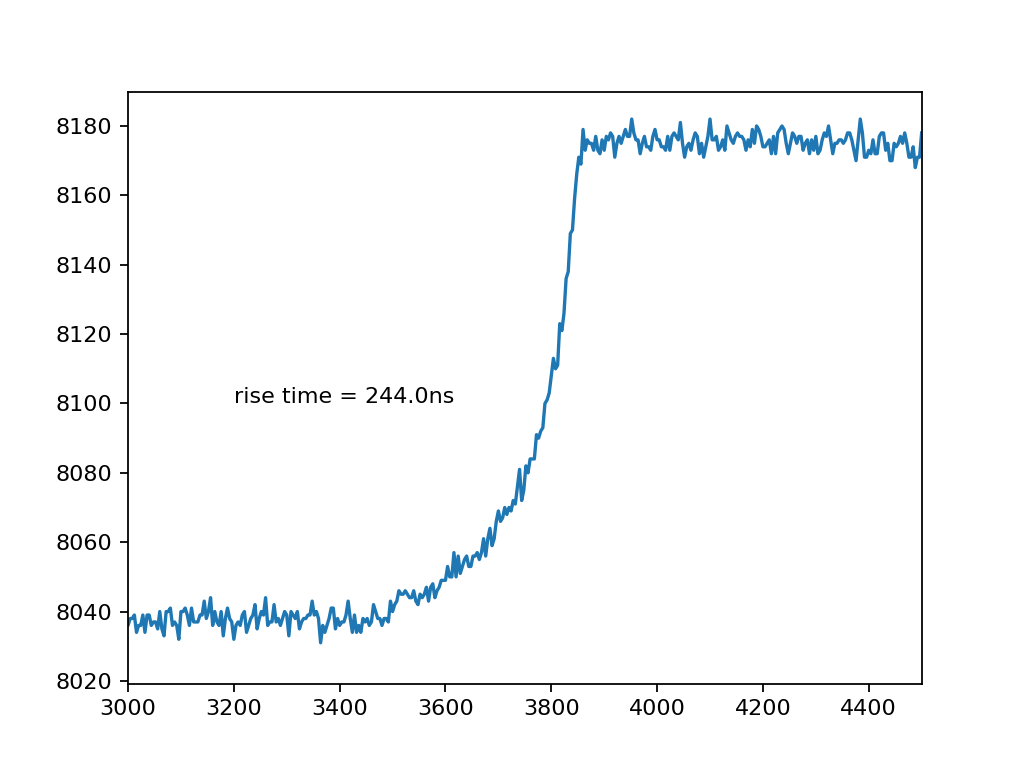

In [241]:
pulse_num=4
plt.figure()
plt.plot(wave_times,shoulder_pulses[pulse_num])
plt.text(3200,8100,'rise time = '+str(round(shoulder_rises[pulse_num]*10**9,2))+'ns')
plt.xlim(3000,4500)
plt.show()

In [228]:
shoulder_rises = rise_times[shoulder_pulse_idx]

<IPython.core.display.Javascript object>


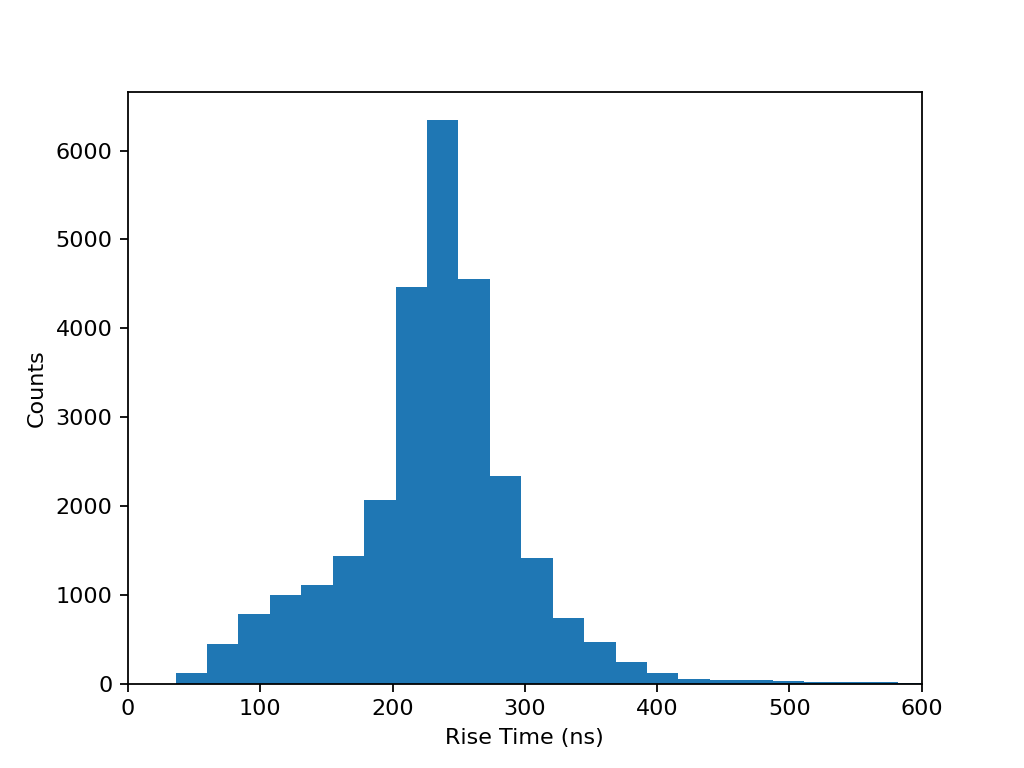

In [235]:
plt.figure()
plt.hist(shoulder_rises*10**9,bins=100)
plt.xlim(0,600)
plt.xlabel('Rise Time (ns)')
plt.ylabel('Counts')
plt.show()

In [237]:
shoulder_rises.mean()*10**9

234.84227106751632